# Определение перспективного тарифа для телеком-компании

## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

### Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Задача**

Скачать данные, подготовить их. Объединить в единый датасет. Проанализировать полученую таблицу. Сделать выводы.

### Шаг 1. Откройте файлы с данными 

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

### Чтение файлов

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

### Шаг 2. Подготовьте данные
- Приведите данные к нужным типам;
- Найдите и исправьте ошибки в данных, если они есть.

Поясните, какие ошибки вы нашли и как их исправили. В данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Изучение первичных данных
Создадим функцию для изученя основных характеристик таблиц

In [3]:
def research(data_file):
    display(data_file.info())
    print('Пропуски')
    display(data_file.isna().sum())
    print('Количество дубликатов', data_file.duplicated().sum())

### Таблица users (информация о пользователях)

In [4]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
research(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

Пропуски


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Количество дубликатов 0


Таблица users (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tarif` — название тарифного плана

В таблице представлены данные о 500 уникальных пользователях. Обнаружено 462 пропуска в колонке даты прекращения пользования тарифом. С ними ничего делать не будем.
В `churn_date` и `reg_date` поменяем тип данных на `datetime64`

In [6]:
# перевод `churn_date` и `reg_date` в datetime64
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Сохраним необходимые данные в отдельную таблицу

In [7]:
users_info = users[['user_id','city','tariff']]

In [8]:
users_info.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


### Таблица `tariffs` (информация о тарифах)

In [9]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица **tariffs** (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

В таблице предсталены характеристики двух тарифов smart и ultra.
Переведем объём мегабайт интернет-трафика, включённого в абонентскую плату в гигабайты

In [10]:
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included']/1024

### Таблица `calls` (информация о звонках)

In [11]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [12]:
research(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

Пропуски


id           0
call_date    0
duration     0
user_id      0
dtype: int64

Количество дубликатов 0


Таблица **calls** (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

202607 строк и 4 колонки. Пропусков и дубликатов не обнаружено.

В `call_date` потребуется поменять тип данных на `datetime64`

Так как по условию «Мегалайн» всегда округляет секунды до минут, то потребуется округлить значения `duration` в большую сторону и поменять тип данных на `int`. Для сводной таблицы добавим колонку месяц

In [13]:
# перевод даты звонка в datetime64
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
# округление длительности звонка в минутах в большую сторону и перевод в int
# calls['duration'] = calls['duration'].apply(np.ceil).astype(int)
calls['duration'] = np.ceil(calls['duration']).astype(int)
# добавление колонки месяца
calls['month'] = calls['call_date'].dt.month 

In [14]:
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


**Посчитайте для каждого пользователя**:
- количество сделанных звонков и израсходованных минут разговора по месяцам;

Суммируем данные о длительности звонков пользователей помесячно. Изменим названия колонок.

In [15]:
user_calls = calls.groupby(['user_id','month'],as_index=False).agg({'duration': ['count','sum']})
user_calls.columns= ['user_id', 'month', 'calls', 'minutes']

In [16]:
user_calls.head()

,user_id,month,calls,minutes
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


### Таблица `internet` (информация об интернет-сессиях)

In [17]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [18]:
# Удалим колонку `Unnamed: 0`
internet.drop(columns=['Unnamed: 0'], inplace=True)

In [19]:
research(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


None

Пропуски


id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Количество дубликатов 0


Таблица **internet** (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

149396 строк и 5 колонок. Пропусков и дубликатов не обнаружено.

В колонке `session_date` потребуется поменять тип данных на `datetime64`

Так как по условию «Мегалайн» всегда округляет мегабайты — до гигабайт, потребуется суммировать значения `mb_used` помесячно и перевести в гигабайты.

In [20]:
# перевод даты интернет-сессии в datetime64
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
# добавление колонки месяца
internet['month'] = internet['session_date'].dt.month 

In [21]:
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


**Посчитайте для каждого пользователя**:
- объем израсходованного интернет-трафика по месяцам;

Суммируем информацию об интернет сессиях пользователей помесячно

In [22]:
user_internet = internet.groupby(['user_id','month'], as_index = False).agg({'mb_used': ['sum']})
user_internet.columns = ['user_id', 'month', 'mb_used']

In [23]:
user_internet.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Посчитаем количество потраченного интернет траффика в гигабайтах, переведем значения в `int`

In [24]:
#user_internet['gb_used'] = user_internet['mb_used'].apply(lambda x: x//1024 + 1 if x%1024 > 0 else x//1024).astype(int)
user_internet['gb_used'] = np.ceil(user_internet['mb_used'] / 1024).astype(int)

In [25]:
#user_internet.drop(columns=['mb_used'], inplace=True)

In [26]:
user_internet.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


Text(0.5, 0, 'Количество Гб')

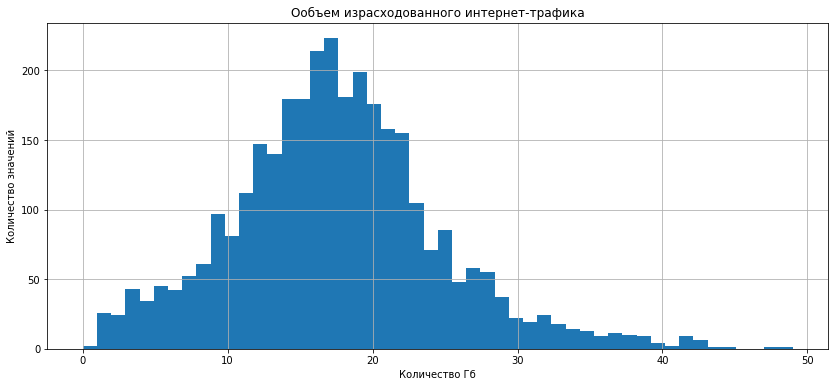

In [27]:
user_internet.gb_used.hist(bins=50,figsize=(14, 6))

plt.title('Ообъем израсходованного интернет-трафика')
plt.ylabel('Количество значений')
plt.xlabel('Количество Гб')

Text(0.5, 0, 'Количество Мб')

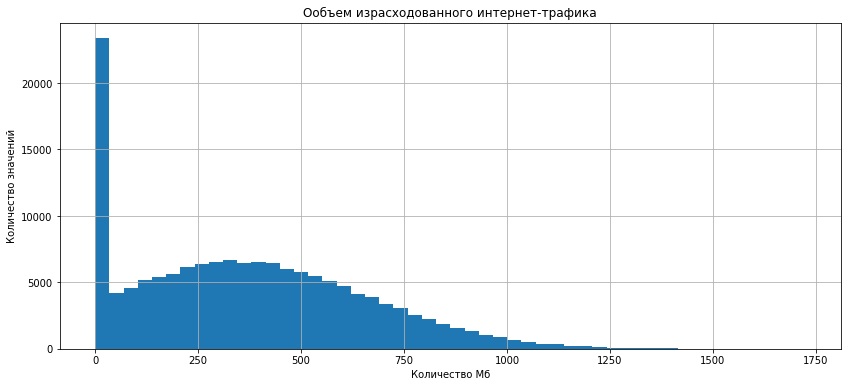

In [69]:
# Комментарий 2
internet.mb_used.hist(bins=50,figsize=(14, 6))

plt.title('Ообъем израсходованного интернет-трафика')
plt.ylabel('Количество значений')
plt.xlabel('Количество Мб')

### Таблица `messages` (информация о сообщениях)

In [29]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [30]:
research(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

Пропуски


id              0
message_date    0
user_id         0
dtype: int64

Количество дубликатов 0


Таблица **messages** (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

123036 строк и 3 колонкb. Пропусков и дубликатов не обнаружено.

В колонке `message_date` потребуется поменять тип данных на `datetime64`

In [31]:
# перевод даты сообщения в datetime64
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
# добавление колонки месяца
messages['month'] = messages['message_date'].dt.month 

In [32]:
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


**Посчитайте для каждого пользователя**:
- количество отправленных сообщений по месяцам;

Сгруппируем информацию о сообщениях по пользователю и месяцу

In [33]:
user_messages = messages.groupby(['user_id','month'],as_index=False).agg({'id':'count'})

In [34]:
user_messages.columns = ['user_id', 'month', 'messages']

In [35]:
user_messages.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Создание единой сводной таблицы

Объединим 3 сводные таблицы с месячными расходами пользователей

In [36]:
user_spend = user_calls.merge(user_internet, on=['user_id','month'],how='outer')
user_spend = user_spend.merge(user_messages, on=['user_id','month'],how='outer')

Проверим объединенную таблицу `user_spend` на пропуски

In [37]:
user_spend.isna().sum()

user_id       0
month         0
calls        40
minutes      40
mb_used      11
gb_used      11
messages    497
dtype: int64

Пропуски возникли по причине отсутствия активности пользователей  в определенных видах услуг. Например кто-то не пользуется интернетом, но активно использует телефон и наоборот. Заменим пропуски на 0

In [38]:
user_spend = user_spend.fillna(0)

In [39]:
user_spend = user_spend.merge(users_info, on='user_id',how='outer')

In [40]:
user_spend.isna().sum()

user_id     0
month       2
calls       2
minutes     2
mb_used     2
gb_used     2
messages    2
city        0
tariff      0
dtype: int64

In [41]:
user_spend[user_spend['month'].isna() == True]

,user_id,month,calls,minutes,mb_used,gb_used,messages,city,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,Волжский,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,NaN,Омск,smart


In [42]:
users[users['user_id'] == 1371]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Оба пропуска касаются абонентов заключивших договор и расторгнувших его в один месяц. Удалим пропуски. Заменим типы данных month, duration, gb_used, messages на int

In [43]:
user_spend = user_spend.dropna()

In [44]:
user_spend[['month', 'minutes', 'gb_used', 'messages']] = user_spend[['month', 'minutes', 'gb_used', 'messages']].astype(int)

In [45]:
user_spend.head()

,user_id,month,calls,minutes,mb_used,gb_used,messages,city,tariff
0,1000,5,22.0,159,2253.49,3,22,Краснодар,ultra
1,1000,6,43.0,172,23233.77,23,60,Краснодар,ultra
2,1000,7,47.0,340,14003.64,14,75,Краснодар,ultra
3,1000,8,52.0,408,14055.93,14,81,Краснодар,ultra
4,1000,9,58.0,466,14568.91,15,57,Краснодар,ultra


Объединим таблицу расходов с таблицей тарифов

In [46]:
user_spend = user_spend.merge(tariffs, left_on='tariff', right_on='tariff_name',how='outer')
user_spend.head()

,user_id,month,calls,minutes,mb_used,gb_used,messages,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,1000,5,22.0,159,2253.49,3,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0
1,1000,6,43.0,172,23233.77,23,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0
2,1000,7,47.0,340,14003.64,14,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0
3,1000,8,52.0,408,14055.93,14,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0
4,1000,9,58.0,466,14568.91,15,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0


**Посчитайте для каждого пользователя**:

- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Создадим функцию рассчитывающую помесячную выручку с каждого пользователя

In [48]:
def payd_over(row):
    minutes_used = row['minutes']
    messages_used = row['messages']
    gb_used = row['gb_used']
    
    minutes_included = row['minutes_included']
    messages_included = row['minutes_included']
    gb_included = row['gb_per_month_included']
    
    rub_monthly_fee = row['rub_monthly_fee']
    
    rub_per_minute = row['rub_per_minute']
    rub_per_message = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    
    if minutes_used > minutes_included:
        extra_minutes_payment = (minutes_used-minutes_included)*rub_per_minute
    else:
        extra_minutes_payment = 0
        
    if messages_used > messages_included:
        extra_messages_payment = (messages_used-messages_included)*rub_per_message
    else:
        extra_messages_payment = 0
        
    if gb_used > gb_included:
        extra_gb_payment = (gb_used-gb_included)*rub_per_gb
    else:
        extra_gb_payment = 0
       
    payment = rub_monthly_fee+extra_minutes_payment+extra_messages_payment+extra_gb_payment
    
    return payment

Применим функцию к сводной таблице и сохраним результат в новом датафрейме

In [49]:
user_spend['payment'] = user_spend.apply(payd_over, axis=1).astype(int)
user_spend.head()

,user_id,month,calls,minutes,mb_used,gb_used,messages,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included,payment
0,1000,5,22.0,159,2253.49,3,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0,1950
1,1000,6,43.0,172,23233.77,23,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0,1950
2,1000,7,47.0,340,14003.64,14,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0,1950
3,1000,8,52.0,408,14055.93,14,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0,1950
4,1000,9,58.0,466,14568.91,15,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,ultra,30.0,1950


In [50]:
df = user_spend[['user_id','month','minutes','gb_used','messages','city','tariff','payment']]
df.head()

,user_id,month,minutes,gb_used,messages,city,tariff,payment
0,1000,5,159,3,22,Краснодар,ultra,1950
1,1000,6,172,23,60,Краснодар,ultra,1950
2,1000,7,340,14,75,Краснодар,ultra,1950
3,1000,8,408,14,81,Краснодар,ultra,1950
4,1000,9,466,15,57,Краснодар,ultra,1950


### Вывод

Нам представлена выборка данных о расходах 500 абонентов компании «Мегалайн» за 2018 год.

В процессе исследования:
- В таблицах users, tariffs, calls, internet данные колонок содержащих дату были заменены на тип datetime64.
- Пропуски в таблице users в значениях churn_date менять не стали, тк по условию если значение пропущено, то тариф ещё действовал на момент выгрузки данных.
- В tariffs объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) пересчитали в гигабайты.
- В calls длительность звонка округлили до минут и перевели  в формат int.
- В internet удалена колонка Unnamed: 0 дублирующая значение индексов. Объём потраченных мегабайт суммированы за месяц, пересчитаны в гигабайты и переведены в int.

Каждую таблицу (кроме tariffs) сгруппировали по идентификатору пользователя и месяцу.
Получившиеся сводные таблицы объединили в единую таблицу user_spend. Пропуски возникающие в процессе объединения были заменены на 0.
Тк не все клиенты использовали предоставленные им минуты или интеренет траффик.
Из user_spend были удалены 2 строки пропусков: абоненты которые заключили договор и расторгли его в течение 1 месяца не воспользовавшись услугами оператора.

Объединив информацию о расходах с информацией о тарифах мы получили новый датафрейм с данными о затратах каждого пользователя.

### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Колисество пользователей каждого тарифа

In [51]:
df.groupby('tariff')['user_id'].nunique()

tariff
smart    350
ultra    148
Name: user_id, dtype: int64

### Описательная статистика по каждому тарифу

In [52]:
display(df.query('tariff == "ultra"').describe().round(2))
df.query('tariff == "smart"').describe().round(2)

,user_id,month,minutes,gb_used,messages,payment
count,985.00,985.00,985.00,985.00,985.00,985.00
mean,1263.09,8.25,526.62,19.49,49.36,2070.15
std,140.69,2.87,317.61,9.85,47.80,376.19
min,1000.00,1.00,0.00,0.00,0.00,1950.00
25%,1143.00,6.00,284.00,12.00,6.00,1950.00
50%,1277.00,9.00,518.00,19.00,38.00,1950.00
75%,1381.00,11.00,752.00,27.00,79.00,1950.00
max,1495.00,12.00,1673.00,49.00,224.00,4800.00


,user_id,month,minutes,gb_used,messages,payment
count,2229.00,2229.00,2229.00,2229.00,2229.00,2229.00
mean,1246.51,8.35,417.93,16.33,33.38,1272.57
std,146.12,2.92,190.31,5.75,28.23,813.58
min,1001.00,1.00,0.00,0.00,0.00,550.00
25%,1121.00,6.00,282.00,13.00,10.00,550.00
50%,1239.00,9.00,422.00,17.00,28.00,994.00
75%,1376.00,11.00,545.00,20.00,51.00,1750.00
max,1499.00,12.00,1435.00,38.00,143.00,6671.00


### Среднее колчество минут разговора в месяц

Text(0.5, 0, 'Длительность разговора мин')

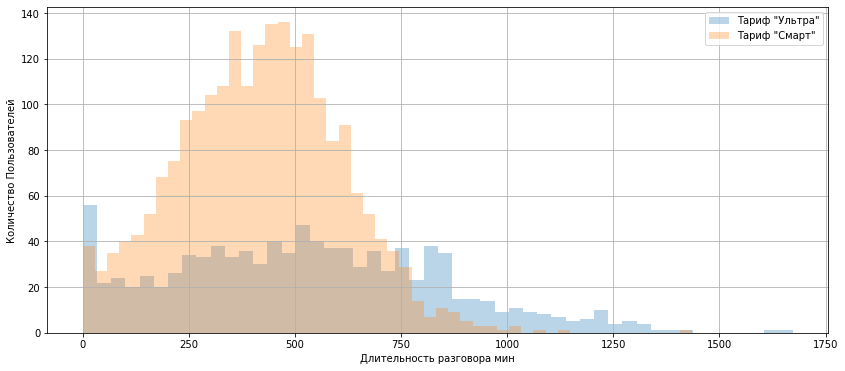

In [53]:
df.query('tariff == "ultra"')['minutes'].hist(bins=50,alpha=0.3,figsize=(14, 6))
df.query('tariff == "smart"')['minutes'].hist(bins=50,alpha=0.3)

plt.legend(['Тариф "Ультра"','Тариф "Смарт"'])
plt.ylabel("Количество Пользователей")
plt.xlabel("Длительность разговора мин")

In [54]:
print('Среднее колчество минут разговора в месяц:')
print ('Тариф "ultra":', df.query('tariff == "ultra"')['minutes'].describe()['mean'].round(2),'минут, ',
      'дисперсия =',(df.query('tariff == "ultra"')['minutes'].describe()['std']**2).round(2),
       'стандартное отклонение =',df.query('tariff == "ultra"')['minutes'].describe()['std'].round(2))

print ('Тариф "smart":', df.query('tariff == "smart"')['minutes'].describe()['mean'].round(2),'минут, ',
       'дисперсия =',(df.query('tariff == "smart"')['minutes'].describe()['std']**2).round(2),
      'стандартное отклонение =',df.query('tariff == "smart"')['minutes'].describe()['std'].round(2))
print()
print('% минут по тарифам',df.groupby('tariff')['minutes'].sum()/df['minutes'].sum())
      


Среднее колчество минут разговора в месяц:
Тариф "ultra": 526.62 минут,  дисперсия = 100873.63 стандартное отклонение = 317.61
Тариф "smart": 417.93 минут,  дисперсия = 36219.32 стандартное отклонение = 190.31

% минут по тарифам tariff
smart    0.642334
ultra    0.357666
Name: minutes, dtype: float64


### Среднее колчество гигабайт интернет-трафика в месяц

In [55]:
print('Среднее колчество гигабайт интернет-трафика в месяц:')
print ('Тариф "ultra" = ', df.query('tariff == "ultra"')['gb_used'].describe()['mean'].round(2),'Гб, ',
      'дисперсия =',(df.query('tariff == "ultra"')['gb_used'].describe()['std']**2).round(2),
       'стандартное отклонение =',df.query('tariff == "ultra"')['gb_used'].describe()['std'].round(2))

print ('Тариф "smart" = ', df.query('tariff == "smart"')['gb_used'].describe()['mean'].round(2),'Гб, ',
       'дисперсия =',(df.query('tariff == "smart"')['gb_used'].describe()['std']**2).round(2),
      'стандартное отклонение =',df.query('tariff == "smart"')['gb_used'].describe()['std'].round(2))

print()
print('% гигабайты по тарифам',df.groupby('tariff')['gb_used'].sum()/df['gb_used'].sum())


Среднее колчество гигабайт интернет-трафика в месяц:
Тариф "ultra" =  19.49 Гб,  дисперсия = 97.09 стандартное отклонение = 9.85
Тариф "smart" =  16.33 Гб,  дисперсия = 33.03 стандартное отклонение = 5.75

% гигабайты по тарифам tariff
smart    0.654634
ultra    0.345366
Name: gb_used, dtype: float64


Text(0.5, 0, 'Количество сообщений')

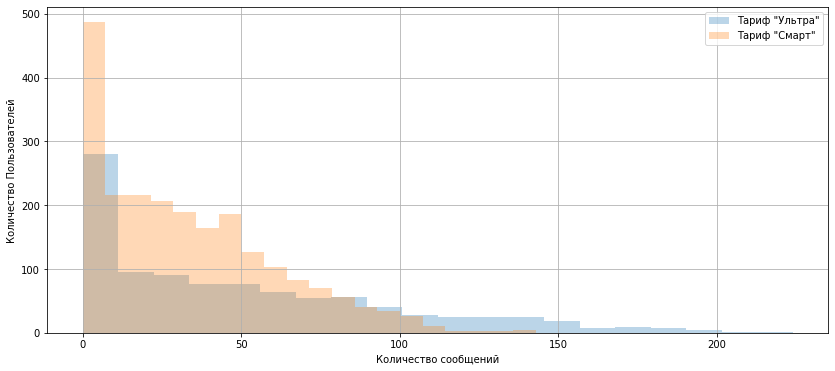

In [56]:
df.query('tariff == "ultra"')['messages'].hist(bins=20,alpha=0.3,figsize=(14, 6))
df.query('tariff == "smart"')['messages'].hist(bins=20,alpha=0.3)

plt.legend(['Тариф "Ультра"','Тариф "Смарт"'])
plt.ylabel("Количество Пользователей")
plt.xlabel("Количество сообщений")

### Среднее колчество сообщений в месяц

In [57]:
print('Среднее колчество сообщений в месяц:')
print('Тариф "ultra" = ', df.query('tariff == "ultra"')['messages'].describe()['mean'].round(2),
      'дисперсия =',(df.query('tariff == "ultra"')['messages'].describe()['std']**2).round(2),
       'стандартное отклонение =',df.query('tariff == "ultra"')['messages'].describe()['std'].round(2))

print('Тариф "smart" = ', df.query('tariff == "smart"')['messages'].describe()['mean'].round(2),
       'дисперсия =',(df.query('tariff == "smart"')['messages'].describe()['std']**2).round(2),
      'стандартное отклонение =',df.query('tariff == "smart"')['messages'].describe()['std'].round(2))

print()
print('% сообщений по тарифам',df.groupby('tariff')['messages'].sum()/df['messages'].sum())

Среднее колчество сообщений в месяц:
Тариф "ultra" =  49.36 дисперсия = 2285.27 стандартное отклонение = 47.8
Тариф "smart" =  33.38 дисперсия = 796.81 стандартное отклонение = 28.23

% сообщений по тарифам tariff
smart    0.604807
ultra    0.395193
Name: messages, dtype: float64


Text(0.5, 0, 'Объём интернет-трафика Гб')

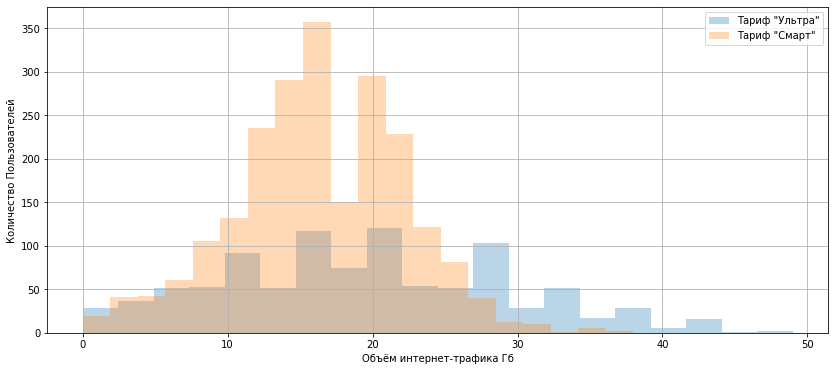

In [58]:
df.query('tariff == "ultra"')['gb_used'].hist(bins=20,alpha=0.3,figsize=(14, 6))
df.query('tariff == "smart"')['gb_used'].hist(bins=20,alpha=0.3)

plt.legend(['Тариф "Ультра"','Тариф "Смарт"'])
plt.ylabel("Количество Пользователей")
plt.xlabel("Объём интернет-трафика Гб")

### Изучение выручки

In [59]:
print('Средний размер выручки в месяц:')
print('Тариф "ultra" = ', df.query('tariff == "ultra"')['payment'].describe()['mean'].round(2),
      'дисперсия =',(df.query('tariff == "ultra"')['payment'].describe()['std']**2).round(2),
       'стандартное отклонение =',df.query('tariff == "ultra"')['payment'].describe()['std'].round(2))

print('Тариф "smart" = ', df.query('tariff == "smart"')['payment'].describe()['mean'].round(2),
       'дисперсия =',(df.query('tariff == "smart"')['payment'].describe()['std']**2).round(2),
      'стандартное отклонение =',df.query('tariff == "smart"')['payment'].describe()['std'].round(2))

print()
print('% выручки по тарифам',df.groupby('tariff')['payment'].sum()/df['payment'].sum())

Средний размер выручки в месяц:
Тариф "ultra" =  2070.15 дисперсия = 141516.75 стандартное отклонение = 376.19
Тариф "smart" =  1272.57 дисперсия = 661916.98 стандартное отклонение = 813.58

% выручки по тарифам tariff
smart    0.58178
ultra    0.41822
Name: payment, dtype: float64


**Посчитаем количество пользователей тарифа Смарт с платежами выше абонентской платы**

In [60]:
user_payment = df.groupby(['user_id','tariff'],as_index=False)['payment'].mean()
user_payment.query('tariff == "smart" and payment > 550')['payment'].describe()

count     327.000000
mean     1359.990082
std       588.065028
min       566.666667
25%       912.666667
50%      1212.333333
75%      1689.000000
max      4254.333333
Name: payment, dtype: float64

In [61]:
user_payment.groupby('tariff')['payment'].agg(['count','sum'])

,count,sum
tariff,,
smart,350,457366.756854
ultra,148,308796.769481


### Вывод

В выборке представлено:
- 350(70%) пользователей тарифа «Смарт»
- 148(30%) тарифа «Ультра»

Распределение минут 
- 64% «Смарт»
- 36% «Ультра»

Распределение интернет-трафика
- 65% «Смарт»
- 35% «Ультра»

Распределение сообщений 
- 60% «Смарт»
- 40% «Ультра»

Распределение выручки
- 58% «Смарт»
- 42% «Ультра»

Это говорит нам о том, что более активны пользователи тарифа «Ультра». Платежи 327(93%) пользователей тарифа «Смарт» превышают абонентскую плату. Как минимум четверть из них (75 процентиль) по платежам уже приблизились к тарифу «Ультра».


### Шаг 4. Проверьте гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Пороговое значение alpha задайте самостоятельно.

Поясните:
- как вы формулировали нулевую и альтернативную гипотезы;
- какой критерий использовали для проверки гипотез и почему.

Нулевую гипотезу формулируем исходя из предположение о том, что не существует связи между двумя наблюдаемыми событиями.
Уровень значимости устанавливаем — 5%, как общепринятое пороговое значение.

### Проверька гипотезы, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформируем гипотезы:

    H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
    H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Зададим 2 выборки для разных тарифов

In [62]:
tariff_smart = df.query('tariff == "smart"')
tariff_ultra = df.query('tariff == "ultra"')

In [63]:
alpha = .05

results = st.ttest_ind(tariff_smart['payment'], tariff_ultra['payment'], equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  3.798003235009034e-261
Отвергаем нулевую гипотезу


### Проверка гипотезы, что средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Сформируем гипотезы:

    H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
    H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Зададим 2 выборки для москвы и других городов

In [64]:
payment_msk = df.query('city == "Москва"')
payment_no_msk = df.query('city != "Москва"')

In [65]:
alpha = .05

results = st.ttest_ind(payment_msk['payment'], payment_no_msk['payment'], equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.425625168367989
Не получилось отвергнуть нулевую гипотезу


In [66]:
df.groupby('tariff')['payment'].mean()

tariff
smart    1272.573800
ultra    2070.152284
Name: payment, dtype: float64

### Шаг 5. Напишите общий вывод

Нам представлена выборка данных о расходах 500 абонентов компании «Мегалайн» за 2018 год.

В процессе исследования:
- В таблицах users, tariffs, calls, internet данные колонок содержащих дату были заменены на тип datetime64.
- Пропуски в таблице users в значениях churn_date менять не стали, тк по условию если значение пропущено, то тариф ещё действовал на момент выгрузки данных.
- В tariffs объём интернет-трафика, включённого в абонентскую плату (в мегабайтах) пересчитали в гигабайты.
- В calls длительность звонка округлили до минут и перевели  в формат int.
- В internet удалена колонка Unnamed: 0 дублирующая значение индексов. Объём потраченных мегабайт суммированы за месяц, пересчитаны в гигабайты и переведены в int.

Каждую таблицу (кроме tariffs) сгруппировали по идентификатору пользователя и месяцу.
Получившиеся сводные таблицы объединили в единую таблицу user_spend. Пропуски возникающие в процессе объединения были заменены на 0.
Тк не все клиенты использовали предоставленные им минуты или интеренет траффик.
Из user_spend были удалены 2 строки пропусков: абоненты которые заключили договор и расторгли его в течение 1 месяца не воспользовавшись услугами оператора.

Объединив информацию о расходах с информацией о тарифах мы получили новый датафрейм с данными о затратах каждого пользователя.

Изучив полученный датафрейм, мы пришли к выводу, что доля пользователей тарифа "Ультра" составляет 30% от всех пользователей. При этом на них приходится 42% выручки.

93% пользователей тарифа «Смарт» превышают абонентскую плату. Как минимум четверть из них (75 процентиль) по платежам уже приблизились к тарифу «Ультра».

Тариф «Ультра» является более выгодным для «Мегалайн», так как он приносит больше выручки на одного абонента. Коммерческому отделу стоит сконцентрироваться на рекламе тарифа «Ультра» среди пользователей тарифа "Смарт", тк около 23%(327/4/350) по сумме платежей приближаются к абонентской плате тарифа «Ультра».

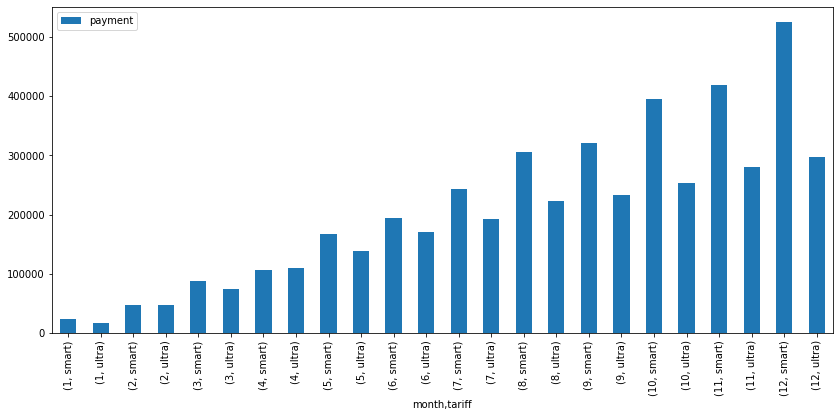

In [67]:
df.groupby(['month','tariff']).agg({'payment':'sum'}).plot(kind='bar', figsize=(14,6))

Очевидно, что выручка растет с каждим месяцем. Доли выручки по каждому тарифу сохраняются.